## Maximum Pooling

In [4]:
# setup and imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings = True

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

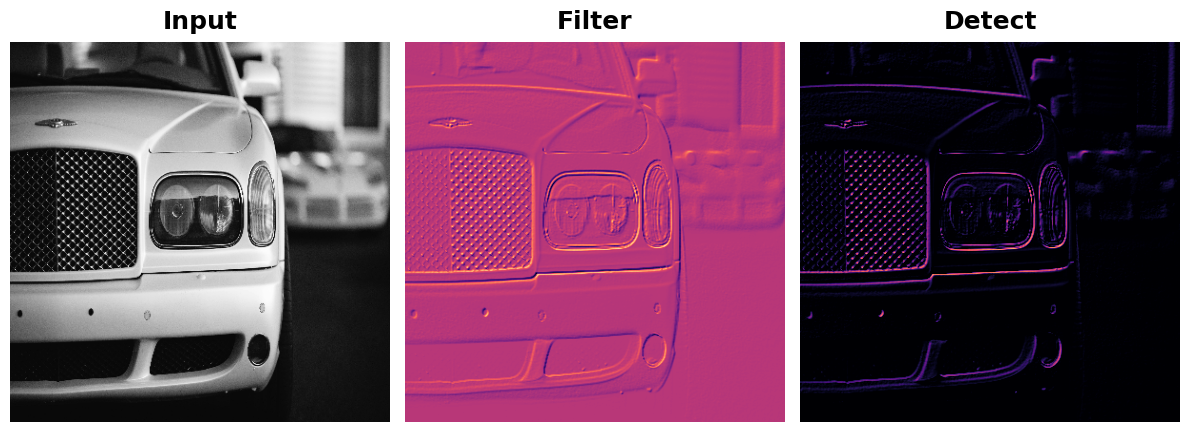

In [2]:
# Set up image and use embossing kernel
img_path = 'resources/car_illus.jpg'
image = tf.io.read_file(img_path)
image = tf.io.decode_jpeg(image, channels = 1)
image = tf.image.resize(image, size=[400,400])

kernel = tf.constant([
    [-2,-2,0],
    [-1,1,1],
    [0,1,2]])

image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape,1,1])
kernel = tf.cast(kernel, dtype=tf.float32)

image_filter = tf.nn.conv2d(input = image,
                            filters=kernel,
                            strides=1,
                            padding="VALID")

image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show()



After passing the input through the filter, the features are detected, but this can be further filtered down by using maximum pooling to condense the features down.

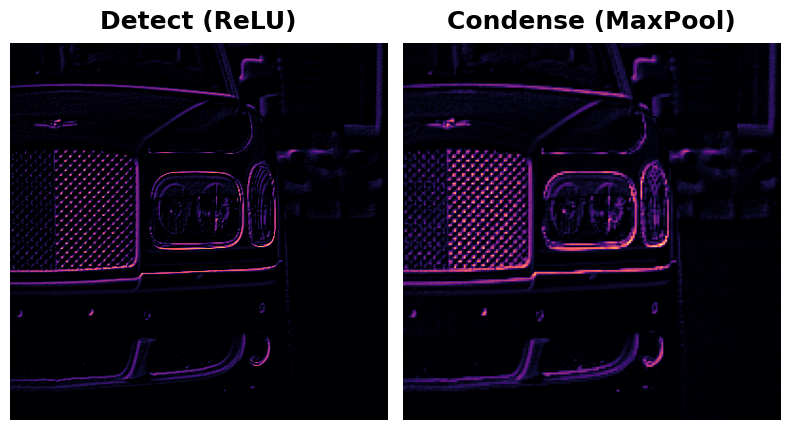

In [3]:
# Set up a Maximum pooling using a 2x2 window
image_condense = tf.nn.pool(input=image_detect,
                            window_shape=(2,2),
                            pooling_type='MAX',
                            strides=(2,2),
                            padding='SAME')

# Visualize the result
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title("Condense (MaxPool)")
plt.show()


By using MaxPooling, we can emphasize the features for better detection. Notice that the lines are much thicker on the condensed image in comparison to the initial result. This process can be repeated to emphasize the effect further.

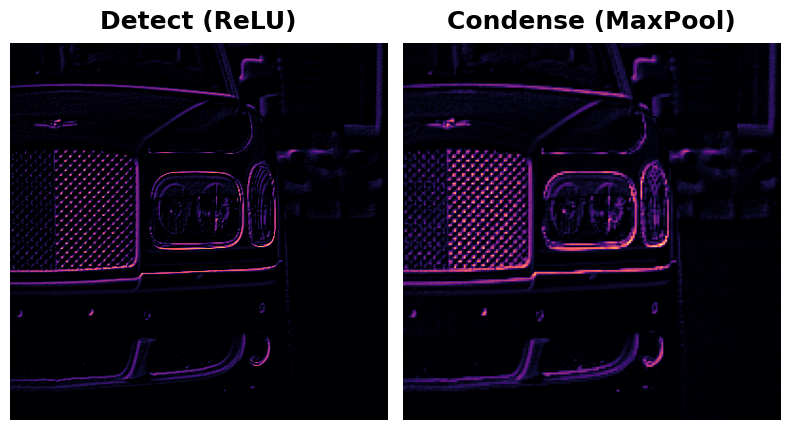

In [4]:
image_condense2 = tf.nn.pool(input=image_condense,
                            window_shape=(2,2),
                            pooling_type='MAX',
                            strides=(2,2),
                            padding='SAME')

image_condense3 = tf.nn.pool(input=image_condense2,
                            window_shape=(2,2),
                            pooling_type='MAX',
                            strides=(2,2),
                            padding='SAME')

image_condense4 = tf.nn.pool(input=image_condense3,
                            window_shape=(2,2),
                            pooling_type='MAX',
                            strides=(2,2),
                            padding='SAME')

# Visualize the result
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title("Condense (MaxPool)")
plt.show()

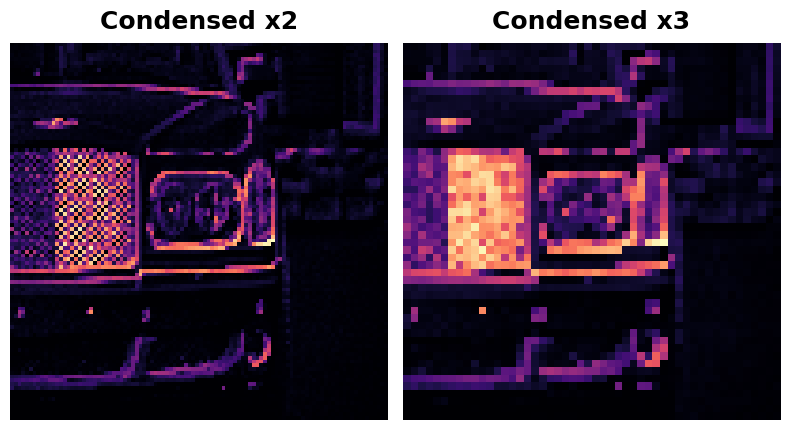

In [5]:

plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_condense2))
plt.axis('off')
plt.title("Condensed x2")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense3))
plt.axis('off')
plt.title("Condensed x3")
plt.show()


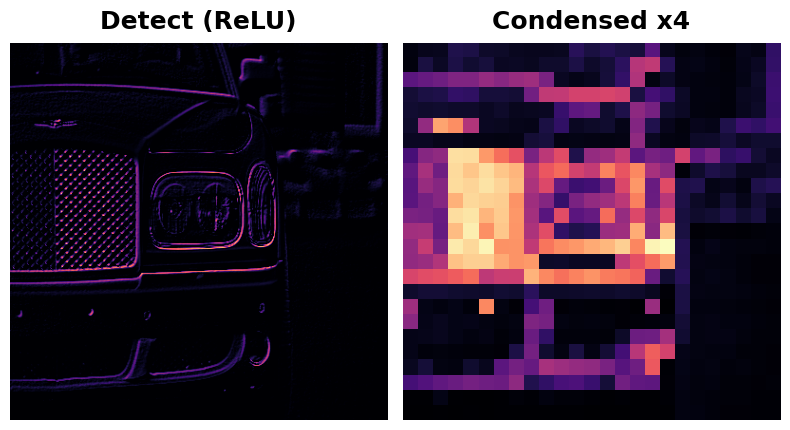

In [6]:

plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense4))
plt.axis('off')
plt.title("Condensed x4")
plt.show()

Condensing the features can reduce the time it takes to process by reducing unimportant details, but condensing too far can lead to incorrect predictions. The act of repeated pooling destroys small translations

## Global Pooling

Global pooling is the natural extreme of regular pooling. Instead of reducing small details, and by extension clutter, Global pooling reduces an image down to only its most dominant color

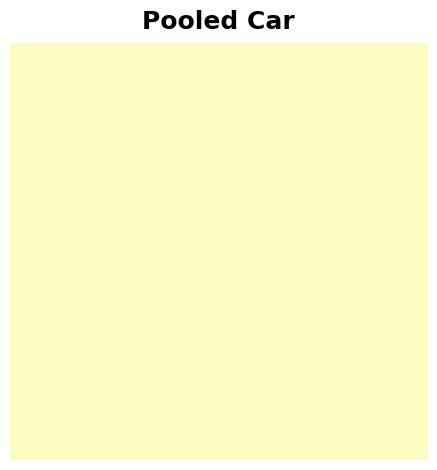

In [7]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
pooled = global_avg_pool(image_detect)

plt.imshow(pooled, vmin=0, vmax=1)
plt.axis('off')
plt.title("Pooled Car")
plt.show()

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load VGG16
pretrained_base = tf.keras.models.load_model('model/vgg16-pretrained-base')

In [2]:

# Define the model
model = keras.Sequential([pretrained_base, layers.GlobalAvgPool2D()])

# Load dataset
ds = image_dataset_from_directory('train/',
                                  labels='inferred',
                                  label_mode='binary',
                                  image_size=[128, 128],
                                  interpolation='nearest',
                                  batch_size=1,
                                  shuffle=True)

ds_iter = iter(ds)

Found 5117 files belonging to 2 classes.


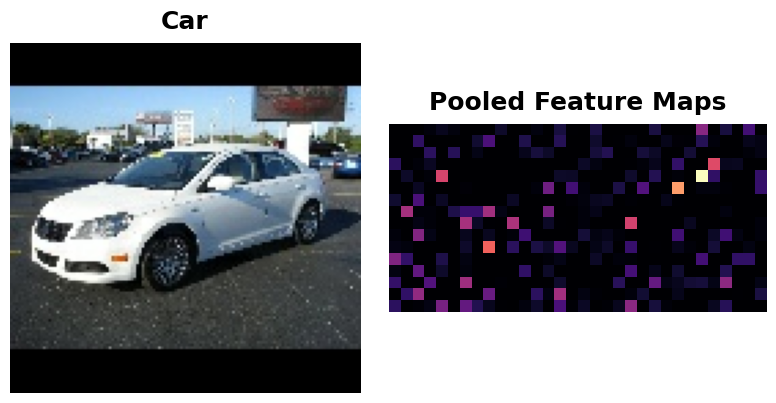

In [6]:
car = next(ds_iter)

car_tf = tf.image.resize(car[0], size=[128, 128])
car_features = model(car_tf)
car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1]).numpy())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Car", "Truck"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Pooled Feature Maps')
plt.axis('off')
plt.show()

This code selects a random image from the training set and tells the pre-trained model to use global pooling to predict whether the image is a car or a truck. Re-running the above cell will select a new image at random to identify.